In [1]:
import collections
import math
import os
import zipfile
import numpy as np
from six.moves import urllib
import tensorflow as tf

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        names = f.namelist()                # ['text8']
        contents = f.read(names[0])         # 크기 : 100,000,000바이트
        text = tf.compat.as_str(contents)   # 크기 : 100,000,000
        return text.split()                 # 갯수 : 17005207
vocabulary = read_data(filename)
print('Data size', len(vocabulary))         # 17005207

Found and verified text8.zip
Data size 17005207


In [3]:
vocabulary_size = 50000
def build_dataset(words, n_words):
    # count : [['UNK', -1], ('the', 1061396), ('of', 593677), ('and', 416629), ...]
    # 크기는 50,000개. UNK가 들어 있고, -1을 뺐으니까 처음에 전달된 크기 사용.
    # 빈도가 높은 5만개 추출.
    # count에 포함된 마지막 데이터는 ('hif', 9). 9번 나왔는데 드물다고 얘기할 수 있는지는 의문.
    unique = collections.Counter(words)             # 중복 단어 제거
    orders = unique.most_common(n_words - 1)        # 단어에 대한 빈도 계산. 갯수를 지정하지 않으면 전체 계산.
    count = [['UNK', -1]]
    count.extend(orders)

    # dictionary : (UNK, 0) (the, 1) (of, 2) (and, 3) (one, 4) (in, 5) (a, 6) (to, 7)
    # 내용을 보면 단어에 번호를 매겼다는 것을 알 수 있다.
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)

    # 위의 코드는 결국 0부터 1씩 증가하는 인덱스를 len(dictionary)로 표현했기 때문에
    # enumerate 함수를 사용한 아래처럼 표현할 수 있다. len(dictionary)는 코드가 모호하다.
    # for i, (word, _) in enumerate(count):
    #     dictionary[word] = i

    # dictionary = {word: i for i, (word, _) in enumerate(count)}

    # 단어 전체에 대해 인덱스 매핑. data는 단어를 가리키는 인덱스 리스트가 된다.
    # 인덱스를 계산하기 위해 딕셔너리 대신 리스트를 사용할 수도 있고, 얼핏 보면 좋아보일 수도 있다.
    # 리스트를 사용하면 이진 검색을 적용해야
    data = []
    for word in words:
        if word in dictionary:          # word가 dictionary에 존재한다면
            index = dictionary[word]
        else:
            index = 0                   # UNK는 0번째에 위치
            count[0][1] += 1            # 갯수 : 418391
        data.append(index)

    # dictionary와 reversed_dictionary 내용
    # 일련번호로 된 key와 value가 의미 있을까? 리스트로 처리하면 되지 않을까?
    # (UNK, 0) (the, 1) (of, 2) (and, 3) (one, 4) (in, 5) (a, 6) (to, 7) (zero, 8) (nine, 9) (two, 10)
    # (0, UNK) (1, the) (2, of) (3, and) (4, one) (5, in) (6, a) (7, to) (8, zero) (9, nine) (10, two)
    # reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    # reversed_dictionary는 0부터 시작하는 일련번호를 갖기 때문에 딕셔너리로 만들면 오히려 어렵고 불편하다.
    # 아래 코드는 리스트와 같다는 것을 증명하는 코드.
    # a = list(dictionary.values())
    # print(type(a), len(a))
    # print(a[0], a[-1])
    #
    # b = list(range(len(dictionary.values())))
    # print(b[0], b[-1])
    #
    # assert a == b

    # reversed_dictionary 대신 key로 구성된 리스트 반환.
    # [(0, UNK) (1, the) (2, of) (3, and) (4, one)]에서 인덱스를 제외하고 구성한 리스트.
    # 원본에서는 dictionary 변수를 반환하고 있는데, 사용하지 않기 때문에 삭제.
    return data, count, list(dictionary.keys())

# data : 단어에 대한 인덱스만으로 구성된 리스트
# count : 단어와 빈도 쌍으로 구성된 리스트. 중요한 변수이지만, 이번 코드에서는 사용 안함.
# ordered_words : 빈도에 따라 정렬된 단어 리스트
data, count, ordered_words = build_dataset(vocabulary, vocabulary_size)

# print('Most common words (+UNK)', count[:5])
# print('Sample data', data[:10], [ordered_words[i] for i in data[:10]], sep='\n')
# print('-'*50)
del vocabulary, count               # 사용하지 않는 변수 삭제

# [출력 결과]
# Most common words (+UNK) [['UNK', 418390], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
# Sample data
# [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
# ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [4]:
# Step 3: skip-gram 모델에 사용할 학습 데이터를 생성할 함수 작성

# 원본에서는 data_index를 전역변수로 처리했는데, 여기서는 매개변수와 반환값으로 변경했다.
# data 변수 또한 전역변수였는데, 첫 번째 매개변수로 전달하도록 변경했다.
def generate_batch(data, batch_size, num_skips, skip_window, data_index):
    ''' Stochastic Gradient Descent 알고리즘에 사용할 minibatch 생성.
    :param data : 단어 인덱스 리스트
    :param batch_size : SGD 알고리즘에 적용할 데이터 갯수. 한 번에 처리할 크기.
    :param num_skips : context window에서 구축할 (target, context) 쌍의 갯수.
    :param skip_window : skip-gram 모델에 사용할 윈도우 크기.
         1이라면 목표 단어(target) 양쪽에 1개 단어이므로 context window 크기는 3이 된다. (단어, target, 단어)
         2라면 5가 된다. (단어 단어 target 단어 단어)
    :param data_index : 첫 번째 context window에 들어갈 data에서의 시작 위치.
    '''
    # 조건이 False라면 비정상 종료
    # num_skips <= batch_size. batch_size는 num_skips의 정수 배.
    # num_skips는 skip_window의 2배 이하.
    # num_skips가 skip_window의 2배일 때, context 윈도우의 모든 쌍 구성
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    temp = 'batch_size {}, num_skips {}, skip_window {}, data_index {}'
    # 최초 : batch_size 8, num_skips 2, skip_window 1, data_index 0
    # 학습 : batch_size 128, num_skips 2, skip_window 1, data_index 640000
    #       data_index는 64로 시작해서 64씩 증가한다. 나머지는 변경되지 않는다.
    # print(temp.format(batch_size, num_skips, skip_window, data_index))

    # ndarray에 값을 주지 않았다면 난수가 사용된다. 앞부분 10개만 표시.
    # batch는 1차원, labels는 2차원.
    # batch  : [0 0 268907754 536870912 -1354956798 32767 32229680 131073]
    # labels : [[0] [0] [268799296] [-805306368] [2] [0] [268811838] [131072]]
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    # span은 assert에 기술한 코드 때문에 항상 num_skips보다 크다.
    span = 2 * skip_window + 1                      # context = skip_window + target + skip_window
    assert span > num_skips

    # deque
    # 처음과 마지막의 양쪽 끝에서 일어나는 입출력에 대해 가장 좋은 성능을 내는 자료구조
    # maxlen 옵션이 없으면 크기 제한도 없고, 있다면 지정한 크기만큼만 사용 가능.
    # maxlen을 3으로 전달하면 3개만 저장할 수 있고, 새로운 요소를 추가하면 반대쪽 요소가 자동으로 삭제됨.
    # 여기서는 자동 삭제 기능 때문에 사용.
    # data_index 번째부터 span 크기만큼 단어 인덱스 저장
    # 첫 번째 context 윈도우 구성
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)   # 다음 단어 인덱스로 이동. len(data) = 17005207

    # 위의 코드를 재구성(에러).
    # data_index는 마지막에서 처음으로 cycle을 구성하기 때문에 오류 발생할 수 있다.
    # buffer = collections.deque(data[data_index:data_index+span], maxlen=span)
    # data_index = (data_index + span) % len(data)

    # skip-gram은 타겟 단어로부터 주변의 컨텍스트 단어를 예측하는 모델이다.
    # 학습하기 전에 단어들을 (target, context) 형태로 변환해 주어야 한다.
    # 바깥 루프는 batch_size // num_skips
    # 안쪽 루프는 num_skips
    # batch_size는 num_skips로 나누어 떨어지기 때문에 정확하게 batch_size만큼 반복
    for i in range(batch_size // num_skips):

        # 원본 코드
        # target = skip_window               # target label은 buffer의 가운데 위치
        # targets_to_avoid = [skip_window]
        #
        # for j in range(num_skips):
        #     while target in targets_to_avoid:
        #         target = random.randrange(span)
        #     targets_to_avoid.append(target)
        #     batch[i * num_skips + j] = buffer[skip_window]
        #     labels[i * num_skips + j, 0] = buffer[target]
        #     print(target, '**')       # (2, 0), (0, 2), (0, 2), (0, 2)

        # 재구성한 코드
        # skip_window는 context의 가운데 위치한 단어의 인덱스
        # skip_window가 3이라면 주변에 3개의 단어씩 위치하게 되고 3+1+3은 7개로 구성된 context가 만들어진다.
        # 읽어올 데이터가 0부터 시작한다면 skip_window는 3이 되고, context의 가운데에 위치한다.
        # 값을 생성할 때, num_skips와 span 중에서 신중하게 선택해야 한다.
        # num_skips는 context로부터 구성할 단어들의 갯수이기 때문에
        # num_skips를 사용하면 context에 포함된 단어들의 모든 인덱스가 반영되지 않을 수 있다.
        # skip_window*2 == num_skips 일 때는 모든 단어를 사용하기 때문에 난수를 사용할 필요가 없다.
        # 여기서는 항상 skip_window는 1, num_skips는 2의 값을 갖는다.
        targets = list(range(span))     # 1. 0부터 span-1까지의 정수로 채운 다음
        targets.pop(skip_window)        # 2. skip_window번째 삭제
        np.random.shuffle(targets)      # 3. 난수를 사용해서 섞는다.

        # batch : target 단어만 들어가고, num_skips만큼 같은 단어가 중복된다.
        # labels : target을 제외한 단어만 들어가고, num_skips만큼 중복될 수 있다.
        start = i * num_skips
        batch[start:start+num_skips] = buffer[skip_window]

        # span이 큰 값이기 때문에 targets에 포함된 모든 값을 사용하지 않을 수 있다.
        # buffer는 numpy 데이터가 아니라서 슬라이스 연산 불가. 어쩔 수 없이 반복문 사용.
        # numpy 배열을 사용하면서 마지막에 있는 num_skips 갯수만큼 사용하는 것이 나을 수도 있다.
        for j in range(num_skips):
            labels[start+j, 0] = buffer[targets[j]]
            # print(targets[j], '**')     # (2, 0), (0, 2), (0, 2), (0, 2)

        # 새로운 요소가 들어가면서 가장 먼저 들어간 데이터 삭제
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # 아래는 generate_batch 함수를 최초 호출한 결과.
    # 오른쪽 출력 결과를 보면, batch와 labels의 관계를 알 수 있다.
    # print(buffer)           # deque([195, 2, 3134], maxlen=3)
    # print(data[:20])        # [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
    # print(batch[:20])       # [3081 3081   12   12    6    6  195  195]
    # print(labels[:20])      # [[5234] [12] [6] [3081] [195] [12] [2] [6]]

    # data_index는 반복문에서 batch_size // num_skips 만큼 증가한다.
    # 최정적인 data_index는 마지막을 지난 위치를 가리키게 되니까, 정확한 계산을 위해 앞으로 돌려놓을 필요가 있다.
    # span에 context 윈도우 전체 크기가 있으니까, span만큼 뒤로 이동한다.
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels, data_index


# generate_batch 함수 테스트. 아래 코드는 뒤쪽에서 사용하지 않는다.
batch, labels, data_index = generate_batch(data, batch_size=8, num_skips=2, skip_window=1, data_index=0)
for i in range(8):
    print('{} {} -> {} {}'.format(batch[i],     ordered_words[batch[i]],
                                  labels[i, 0], ordered_words[labels[i, 0]]))
# [출력 결과]
# 3081 originated -> 12 as
# 3081 originated -> 5234 anarchism
# 12 as -> 6 a
# 12 as -> 3081 originated
# 6 a -> 195 term
# 6 a -> 12 as
# 195 term -> 2 of
# 195 term -> 6 a


3081 originated -> 5234 anarchism
3081 originated -> 12 as
12 as -> 6 a
12 as -> 3081 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


In [5]:
# Step 4: skip-gram 모델 구축
# 실행할 때마다 다른 결과가 나오는 것은 표시하려고 하는 샘플이 달라지기 때문.
# 아래 코드처럼 같은 값을 주면 항상 같은 단어에 대해 유사어를 보여준다.
# 그러나, 텐서플로우에서 사용하는 난수 때문에 유사어는 계속해서 달라진다.
# valid_examples = np.array([80, 84, 33, 81, 93, 17, 36, 82, 69, 65, 92, 39, 56, 52, 51, 32])

# numpy와 tensorflow의 난수를 모두 고정시키면 항상 같은 결과를 얻을 수 있다.
# seed를 고정시켜도 같은 결과를 얻을 수 있다. 다만 함수 호출은 난수를 사용하기 전에 일어나야 한다.
np.random.seed(1)
tf.set_random_seed(1)

# [출력 결과] seed가 1일 때, 101번 반복.
# Nearest to over: codify, maxima, asahi, varied, filament, prey, undercut, adoration,
# Nearest to war: enthusiastically, cephalon, the, as, franco, brent, of, been,
# Nearest to this: orthopedic, sla, kazakhstan, batcave, pusan, nineteen, mortar, state,
# Nearest to years: disengagement, basileus, canis, soldiery, sweeteners, foundations, polymorphism, surrey,
# Nearest to often: porgy, zero, aborted, volcanism, concealment, have, verses, bakery,
# Nearest to three: extinguished, eris, deanna, y, enders, cooled, wickedness, remus,
# Nearest to he: lucrezia, berenson, frustrating, acetylcholine, patriarchy, iggy, enacts, borgir,
# Nearest to states: hak, hung, mane, july, weakened, ambients, harder, magic,
# Nearest to may: discussions, balboa, hypersonic, subjugation, drawing, archaelogical, revitalization, ski,
# Nearest to time: adding, offers, abbey, socony, hohenstaufen, boiler, menstrual, disproved,
# Nearest to system: parchment, bifurcation, awareness, footprint, ajaccio, onetime, demoscene, smarter,
# Nearest to have: franks, the, fashioning, eugen, anarchism, chelmsford, christian, heizei,
# Nearest to many: anarchist, from, rosser, was, all, crowned, wine, believe,
# Nearest to most: modern, and, monetarism, of, prix, ned, magnets, balancing,
# Nearest to more: booby, gradually, broadcast, moynihan, logistical, conflated, dtd, tok,
# Nearest to be: euripides, to, the, think, gabor, lysis, confining, nbs,

batch_size = 128        # 일반적으로 16 <= batch_size <= 512
embedding_size = 128    # embedding vector 크기
skip_window = 1         # target 양쪽의 단어 갯수
num_skips = 2           # 컨텍스트로부터 생성할 레이블 갯수

# valid_examples : [80 84 33 81 93 17 36 82 69 65 92 39 56 52 51 32]
# replace는 중복 허용 안함. 100보다 작은 정수에서 16개 고르기.
valid_size = 16     # 유사성을 평가할 단어 집합 크기
valid_window = 100  # 앞쪽에 있는 분포들만 뽑기 위한 샘플
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # negative 샘플링 갯수

# valid_dataset은 valid_examples 배열의 tf 상수 배열.
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# NCE loss 변수. weights는 (50000, 128), biases는 (50000,).
truncated = tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size))
nce_weights = tf.Variable(truncated)
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# embeddings 벡터. embed는 바로 아래 있는 tf.nn.nce_loss 함수에서 단 1회 사용
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# 배치 데이터에 대해 NCE loss 평균 계산
nce_loss = tf.nn.nce_loss(weights=nce_weights,
                          biases=nce_biases,
                          labels=train_labels,
                          inputs=embed,
                          num_sampled=num_sampled,
                          num_classes=vocabulary_size)
loss = tf.reduce_mean(nce_loss)

# SGD optimizer
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# 유사도를 계산하기 위한 모델. 학습 모델은 optimizer까지 구축한 걸로 종료.
# minibatch 데이터(valid embeddings)와 모든 embeddins 사이의 cosine 유사도 계산
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# print(valid_examples)               # [97 11 15 75 47 64 62 36 39 77 12 91 20  3 84 68]
# print(valid_dataset)                # (16,), int32)
# print('------------')
# print(embeddings)                   # float32, (50000, 128)
# print(embed)                        # float32, (128, 128)
# print(truncated)                    # float32, (50000, 128)
# print(nce_weights)                  # float32, (50000, 128)
# print(nce_biases)                   # float32, (50000,)
# print('------------')
# print(loss)                         # float32, ()
# print(norm)                         # float32, (50000, 1)
# print(normalized_embeddings)        # float32, (50000, 128)
# print(valid_embeddings)             # float32, (16, 128)
# print(similarity)                   # float32, (16, 50000)
# print('------------')


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
num_steps = 1000001             # 마지막 반복을 출력하기 위해 +1.

with tf.Session() as session:
    session.run(tf.global_variables_initializer())

    average_loss, data_index = 0, 0
    for step in range(num_steps):
        batch_inputs, batch_labels, data_index = generate_batch(data, batch_size, num_skips, skip_window, data_index)

        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        # 마지막 2000번에 대한 평균 loss 표시
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print('Average loss at step {} : {}'.format(step, average_loss))
            average_loss = 0

        # 중간 결과 표시. 엄청난 비용이 발생하는 작업. 500번마다 적용할 경우 20%까지의 성능 감소 발생
        if step % 10000 == 0:
            # 16개의 단어로부터 vocabulary에 포함된 모든 단어까지의 거리 계산
            # 샘플 단어 1개당 50000번 계산
            # valid_dataset에 전달된 인덱스를 사용해서 유사도 계산
            # valid_dataset은 valid_examples로 만든 텐서플로우 상수. 결국은 같은 값.
            sim = similarity.eval()         # (16, 50000)

            for i in range(valid_size):
                valid_word = ordered_words[valid_examples[i]]

                # argsort 함수는 배열이 정렬되었을 때의 값들에 대한 순서 리스트 반환
                # x = np.array([9, 4, 6])
                # y = np.argsort(x)         # [1, 2, 0]
                # 순서대로 나열하면 [4, 6, 9]가 되어야 하므로
                # 0번째는 4의 인덱스, 1번째는 6의 인덱스, 2번째는 9의 인덱스가 오게 된다.
                #
                # 가장 가까운 이웃 갯수. 0번째는 자기 자신.
                # 전체 배열에서 [1:top_k + 1] 앞부분 8개만 슬라이싱.
                # sim 앞에 - 기호를 붙여서 음수로 변환한 것은 정렬을 거꾸로 하기 위해서. 앞쪽 부분을 발췌할거니까.
                # argsort 함수는 reverse 옵션이 없다.
                # 0번째가 자기자신이라는 것은 0번째에 있는 인덱스가 가리키는 값이 가장 크다는 것을 뜻한다.
                # 해당 단어와 가장 가까운 것은 자기자신이기 때문에 발생하는 현상.
                # sim에서 i번째는 valid_dataset에서의 i번째 단어에 대한 유사도라는 뜻이다. valid_dataset에 대해 처리했으니까.
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]

                # 데이터 확인
                # distances = (-sim[i, :]).argsort()
                # print('nearest', distances[:5])             # nearest [   32 16641     7     1  1811]
                # print('앞쪽 유사도', sim[i, distances[:5]])    # 앞쪽 유사도 [ 0.99999994  0.34827131  0.34123397  0.3368538   0.33285105]
                # print('뒤쪽 유사도', sim[i, distances[-5:]])   # 뒤쪽 유사도 [-0.32242468 -0.33061796 -0.332335   -0.33657372 -0.33887321]

                # 재구성한 코드.
                # 1. 단순하게 sim 배열의 i번째 데이터를 정렬하기 위한 것이므로 i번째라고 표시하는 것이 좋다.
                # nearest = (-sim[i]).argsort()[1:top_k + 1]
                #
                # 2. 뒤집어서 정렬하는 것보다 정렬한 다음에 마지막을 발췌해서 뒤집는 것이 훨씬 좋다.
                # nearest = sim[i].argsort()[-top_k - 1:-1][::-1]

                # log_str = ''
                # for k in range(top_k):
                #     close_word = ordered_words[nearest[k]]
                #     log_str += close_word + ', '
                # print('Nearest to {}: {}'.format(valid_word, log_str))

                # 재구성한 코드.
                # 1. nearest에 대해 반복하면 코드가 간결해진다.
                # log_str = ''
                # for k in nearest:
                #     log_str += ordered_words[k] + ', '
                # print('Nearest ** {}: {}'.format(valid_word, log_str))
                #
                # 2. 컴프리헨션을 사용하면 가장 쉽고 좋은 코드가 나온다.
                # log_str = ', '.join([ordered_words[k] for k in nearest])
                # print('Nearest -- {}: {}'.format(valid_word, log_str))

    # final_embeddings는 normalized_embeddings 크기와 같고, 다음 단계에서 시각화하는 용도로 사용.
    # ndarray, 크기는 (vocabulary_size, embedding_size), (50000, 128)
    final_embeddings = normalized_embeddings.eval()


Average loss at step 0 : 249.3284912109375
Average loss at step 2000 : 114.25022161006927
Average loss at step 4000 : 52.115825917482375
Average loss at step 6000 : 33.14424011635781
Average loss at step 8000 : 23.396853813171386
Average loss at step 10000 : 18.11160272049904
Average loss at step 12000 : 14.016100749492646
Average loss at step 14000 : 11.71606642818451
Average loss at step 16000 : 9.914080913186073
Average loss at step 18000 : 8.36146148633957
Average loss at step 20000 : 8.119392988443375
Average loss at step 22000 : 7.02796845138073
Average loss at step 24000 : 6.9587489091157915
Average loss at step 26000 : 6.872479678750038
Average loss at step 28000 : 6.364838750720024
Average loss at step 30000 : 5.945700949072838
Average loss at step 32000 : 5.946632951378822
Average loss at step 34000 : 5.72102047586441
Average loss at step 36000 : 5.779967572808266
Average loss at step 38000 : 5.524989888191223
Average loss at step 40000 : 5.254858914494514
Average loss at ste

Average loss at step 346000 : 4.184624048829079
Average loss at step 348000 : 4.311757612228393
Average loss at step 350000 : 4.32398324227333
Average loss at step 352000 : 4.332639204144478
Average loss at step 354000 : 4.329873415827751
Average loss at step 356000 : 4.380453872203827
Average loss at step 358000 : 4.30005242061615
Average loss at step 360000 : 4.305896747589111
Average loss at step 362000 : 4.326783212065696
Average loss at step 364000 : 4.222182429611683
Average loss at step 366000 : 4.303893968105316
Average loss at step 368000 : 4.222058535277844
Average loss at step 370000 : 4.304370696544647
Average loss at step 372000 : 4.301287950336933
Average loss at step 374000 : 4.291102653741836
Average loss at step 376000 : 4.285302308917045
Average loss at step 378000 : 4.330278534770012
Average loss at step 380000 : 4.269780728697777
Average loss at step 382000 : 4.130178063869477
Average loss at step 384000 : 4.262787634849548
Average loss at step 386000 : 4.2768266952

Average loss at step 688000 : 4.227275071501732
Average loss at step 690000 : 4.221745761394501
Average loss at step 692000 : 4.236149248123169
Average loss at step 694000 : 4.22125094974041
Average loss at step 696000 : 4.167827295660973
Average loss at step 698000 : 4.096292117834091
Average loss at step 700000 : 4.211696323394776
Average loss at step 702000 : 4.194914896488189
Average loss at step 704000 : 4.159717315673828
Average loss at step 706000 : 4.196603992819786
Average loss at step 708000 : 4.215648978948593
Average loss at step 710000 : 4.177570579051971
Average loss at step 712000 : 4.229736673355102
Average loss at step 714000 : 4.20773536658287
Average loss at step 716000 : 4.13883310508728
Average loss at step 718000 : 4.101051759958267
Average loss at step 720000 : 4.205471613764763
Average loss at step 722000 : 4.197260020017624
Average loss at step 724000 : 4.19689583158493
Average loss at step 726000 : 4.196776885390282
Average loss at step 728000 : 4.148536984682

OVER


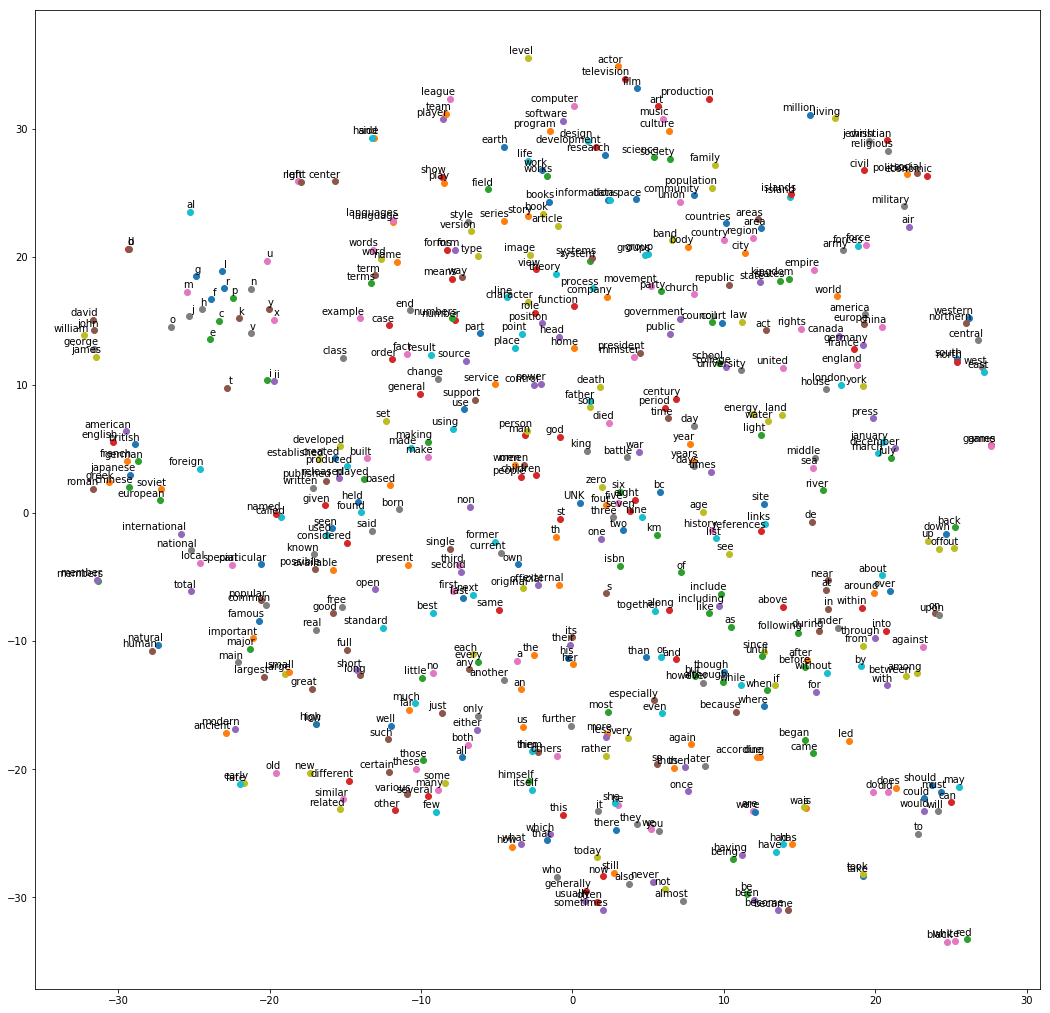

In [9]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))        # in inches

    # 원본 코드.
    # 해당 좌표에 점을 표시하고, 오른쪽/하단 정렬로 단어를 표시한다.
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i]

        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    # 재구성한 코드
    # for (x, y), label in zip(low_dim_embs, labels):
    #     plt.scatter(x, y)
    #     plt.annotate(label,
    #                  xy=(x, y),
    #                  xytext=(5, 2),
    #                  textcoords='offset points',
    #                  ha='right',
    #                  va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    # low_dim_embs 내부 갯수와 n_components가 같아야 한다.
    # n_components : 차원. default는 2.
    # perplexity : 가장 가까운 이웃 갯수. 보통 5~50. default는 30.
    # n_iter : 최적화에 사용할 반복 횟수. 최소 200. default는 1000.
    # init : embedding 초기화 방법. random과 pca 중에서 선택. pca가 보다 안정적. default는 random.
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

    # plot 갯수. 50000개의 embeddings로부터 앞쪽 일부만 사용.
    # low_dim_embs에는 변환된 좌표 x, y가 들어있다.
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only])     # (500, 2)
    labels = ordered_words[:plot_only]                                  # 재구성한 코드
    # labels = [ordered_words[i] for i in range(plot_only)]             # 원본 코드

    plot_with_labels(low_dim_embs, labels)
    print("OVER")

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
